# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [37]:
import pandas as pd
property_stat = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
property_stat.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [38]:
property_stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

### Вывод

Таблица содержит 23699 строк. В столбцах 'ceiling_height', 'floors_total', 'living_area', 'is_apartment', 'kitchen_area',
'balcony', ''

### Шаг 2. Предобработка данных

In [39]:
# В столбце 'ceiling_height' в половине случаевне указана высота потолков. 
#В эти строки имеет смыл поставить замену, так как,возможно, их пропуски означают стандартную высоту потолков.
#Посмотрим описание значаний столбца:
property_stat['ceiling_height'].describe()# медиана имеет значение 2.52

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

In [40]:
property_stat['ceiling_height'].value_counts()#наиболее часто встречающееся значение 2.5

2.50      3515
2.60      1646
2.70      1574
3.00      1112
2.80       993
          ... 
27.50        1
5.00         1
3.59         1
4.80         1
100.00       1
Name: ceiling_height, Length: 183, dtype: int64

In [41]:
#Заменим пустые значения столбца 'ceiling_height' на 2.5:
property_stat['ceiling_height']=property_stat['ceiling_height'].fillna(2.5)
# Проверка замены:
property_stat['ceiling_height'].isna().sum()

0

In [42]:
#Проверим, можно ли заменить пустые значения в столбце 'floors_total'. Возможно они означают наличие только одного этажа в здании:
property_stat.query('floors_total=="NaN"').head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
186,12,11640000.0,65.2,2018-10-02T00:00:00,2,2.5,NaN,30.80,4,NaN,...,12.00,NaN,Санкт-Петербург,39197.0,12373.0,1.0,123.0,0.0,NaN,49.0
237,4,2438033.0,28.1,2016-11-23T00:00:00,1,2.5,NaN,20.75,1,NaN,...,NaN,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,251.0
457,4,9788348.0,70.8,2015-08-01T00:00:00,2,2.5,NaN,38.40,12,NaN,...,10.63,0.0,Санкт-Петербург,37364.0,8322.0,2.0,309.0,2.0,706.0,727.0
671,4,6051191.0,93.6,2017-04-06T00:00:00,3,2.5,NaN,47.10,8,NaN,...,16.80,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,123.0
1757,5,3600000.0,39.0,2017-04-22T00:00:00,1,2.5,NaN,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,77.0


In [43]:
property_stat['floors_total'].value_counts()

5.0     5788
9.0     3761
16.0    1376
12.0    1362
4.0     1200
10.0    1174
25.0    1075
6.0      914
17.0     833
3.0      668
7.0      592
14.0     553
18.0     505
24.0     469
8.0      390
2.0      383
15.0     365
23.0     352
19.0     339
22.0     286
20.0     271
13.0     229
11.0     203
27.0     164
21.0     158
26.0     124
1.0       25
35.0      24
28.0      21
36.0       3
29.0       1
60.0       1
33.0       1
52.0       1
37.0       1
34.0       1
Name: floors_total, dtype: int64

In [44]:
# Узнать этажность здания не представляется возможным. Но оставлять пустыи значения не будем. Заменим на 0
# При этом столбец 'floors_total' имеет тип float. Нужно заменить на int, так как столбец отражает целые числа.
property_stat['floors_total']=property_stat['floors_total'].fillna(0).astype('int')

# Пропущенные значения в столбцах 'living_area' и 'kitchen_area' оставим бех изменений. Так как пропущенные значения могут 
# означать, что жилая площадь ещё не определена (напр. для квартир со свободной планировкой). Не получиться посчитать их из
# общей площади. Так как в квартирах есть нежилые зоны, площадь которых не указана в таблице.


#Заменяем пропущенные значения в столюце 'is_apartment' на 0,
# так как если бы это были апартаменты, то их бы не забыли указать в объявлении. Меняем тип данных.
property_stat['is_apartment']=property_stat['is_apartment'].fillna(0).astype('int')


#Заменим тип данных в столбцах 'studio' и 'open_plan' на int:
property_stat['studio']=property_stat['studio'].astype('int')
property_stat['open_plan']=property_stat['open_plan'].astype('int')


#Заменяем пропущенные значения в столбце 'balcony' на 0 и меняем тип данных в столбце 'balcony'
property_stat['balcony']=property_stat['balcony'].fillna(0).astype('int')


# менет тип занчений в столбце 'rooms' на int:
property_stat['rooms']=property_stat['rooms'].astype('int')


In [45]:
property_stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          23699 non-null float64
floors_total            23699 non-null int64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null int64
studio                  23699 non-null int64
open_plan               23699 non-null int64
kitchen_area            21421 non-null float64
balcony                 23699 non-null int64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around3000 

### Вывод

К возникновению пропусков в одних случаях виноват человеческий фактор(продавец забыл или не посчитал нужным указать какие-либо данные), в других пропуски вызваны техническимифакторами.
Там,  где данные были пропущены пользователем пропуски были заполнены по необходимости. А пропуски, полученные на автоматической основе остались 

### Шаг 3. Посчитайте и добавьте в таблицу

In [46]:
# Добавляем столбец с ценой за квадратный метр: 
property_stat['price_for_metr']=property_stat['last_price']/property_stat['total_area']

#Переводим строки в даты в столбце 'first_day_exposition'
property_stat['first_day_exposition']=pd.to_datetime(property_stat['first_day_exposition'], format='%Y.%m.%dT%H:%M:%S')

#Сгруппируем квартиры по этажам:
property_stat['floor_type'] = (
        property_stat['floor']
        .where(property_stat['floor']!=1, 'Первый')
        .where((property_stat['floor']/property_stat['floors_total'])!=1, 'Последний')
        .where((property_stat['floor']==1) | (property_stat['floor']/property_stat['floors_total']==1), 'Другой')       
) 

# Посчитаем отношение жилой площади к общей:
property_stat['ratio_living']=property_stat['living_area']/property_stat['total_area']

# Посчитаем отношение кухонной зоны к общей:
property_stat['ratio_kithen']=property_stat['kitchen_area']/property_stat['total_area']

property_stat.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_for_metr,floor_type,ratio_living,ratio_kithen
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,0,...,16028.0,1.0,482.0,2.0,755.0,NaN,120370.370370,Другой,0.472222,0.231481
1,7,3350000.0,40.4,2018-12-04,1,2.50,11,18.6,1,0,...,18603.0,0.0,NaN,0.0,NaN,81.0,82920.792079,Первый,0.460396,0.272277
2,10,5196000.0,56.0,2015-08-20,2,2.50,5,34.3,4,0,...,13933.0,1.0,90.0,2.0,574.0,558.0,92785.714286,Другой,0.612500,0.148214
3,0,64900000.0,159.0,2015-07-24,3,2.50,14,NaN,9,0,...,6800.0,2.0,84.0,3.0,234.0,424.0,408176.100629,Другой,NaN,NaN
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,0,...,8098.0,2.0,112.0,1.0,48.0,121.0,100000.000000,Другой,0.320000,0.410000


In [47]:
property_stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 26 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int64
ceiling_height          23699 non-null float64
floors_total            23699 non-null int64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null int64
studio                  23699 non-null int64
open_plan               23699 non-null int64
kitchen_area            21421 non-null float64
balcony                 23699 non-null int64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_aro

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

### 4.1.Изучаем параметры, от которых может зависить цена квартиры

In [48]:
#построим таблицу со столбцами для анализ:
property_stat_part=property_stat.loc[:,['rooms','total_area','days_exposition','last_price','ceiling_height']] 
print(property_stat_part.describe(include='all'))

              rooms    total_area  days_exposition    last_price  \
count  23699.000000  23699.000000     20518.000000  2.369900e+04   
mean       2.070636     60.348651       180.888634  6.541549e+06   
std        1.078405     35.654083       219.727988  1.088701e+07   
min        0.000000     12.000000         1.000000  1.219000e+04   
25%        1.000000     40.000000        45.000000  3.400000e+06   
50%        2.000000     52.000000        95.000000  4.650000e+06   
75%        3.000000     69.900000       232.000000  6.800000e+06   
max       19.000000    900.000000      1580.000000  7.630000e+08   

       ceiling_height  
count    23699.000000  
mean         2.666160  
std          0.995355  
min          1.000000  
25%          2.500000  
50%          2.500000  
75%          2.700000  
max        100.000000  


In [49]:
property_stat_part.describe(include='all')

,rooms,total_area,days_exposition,last_price,ceiling_height
count,23699.000000,23699.000000,20518.000000,2.369900e+04,23699.000000
mean,2.070636,60.348651,180.888634,6.541549e+06,2.666160
std,1.078405,35.654083,219.727988,1.088701e+07,0.995355
min,0.000000,12.000000,1.000000,1.219000e+04,1.000000
25%,1.000000,40.000000,45.000000,3.400000e+06,2.500000
50%,2.000000,52.000000,95.000000,4.650000e+06,2.500000
75%,3.000000,69.900000,232.000000,6.800000e+06,2.700000
max,19.000000,900.000000,1580.000000,7.630000e+08,100.000000


#### Построим гистограмму и диаграмму размаха для анализа площади:


[[<matplotlib.axes._subplots.AxesSubplot object at 0x7fce4d9e8310>]]


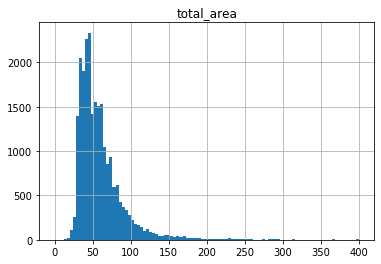

AxesSubplot(0.125,0.125;0.775x0.755)


(0, 300)

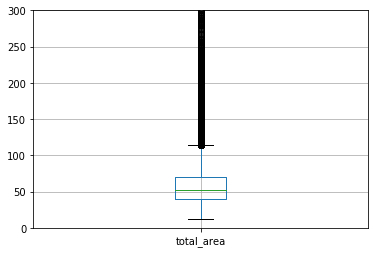

In [50]:
import matplotlib.pyplot as plt
print(property_stat.hist(['total_area'], bins=(100), range=(0,400)))
plt.show()
print(property_stat.boxplot(['total_area']))
plt.ylim(0, 300)


#### Построим гистограмму и диаграмму размаха для анализа цен:

[[<matplotlib.axes._subplots.AxesSubplot object at 0x7fce4a8dad90>]]


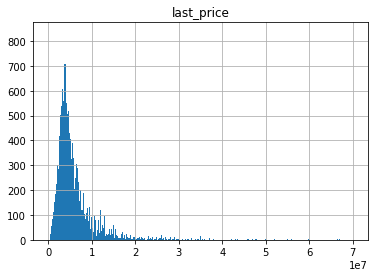

AxesSubplot(0.125,0.125;0.775x0.755)


(-100000, 60000000.0)

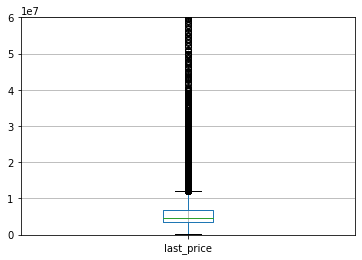

In [51]:
#Построим гистограмму и диаграмму размаха для анализа цен:
print(property_stat.hist(['last_price'], bins=(500), range=(0,70000000)))
plt.show()
print(property_stat.boxplot(['last_price']))
plt.ylim(-100000, 6.000000e+07)      

#### Построим гистограмму и диаграмму размаха для анализа числа комнат:

1    138
0     59
Name: studio, dtype: int64
[[<matplotlib.axes._subplots.AxesSubplot object at 0x7fce4daf7410>]]


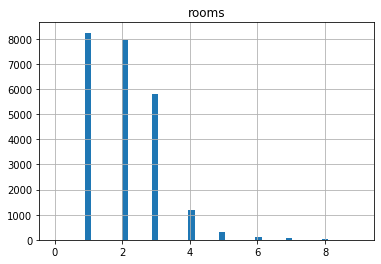

AxesSubplot(0.125,0.125;0.775x0.755)


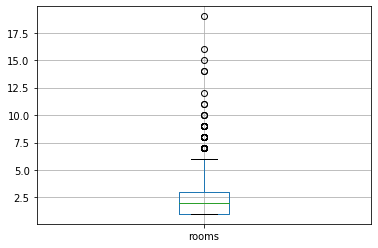

In [52]:
print(property_stat[property_stat['rooms']==0]['studio'].value_counts())# значения комнат=0 обозначает квартиру студию
#заменим 0 на 1:
property_stat['rooms'].replace(0,1, inplace=True)

#Построим гистограмму и диаграмму размаха для анализа площади:
print(property_stat.hist(['rooms'], bins=(50), range=(0,9)))
plt.show()
print(property_stat.boxplot(['rooms']))


#### Построим гистограмму и диаграмму размаха для анализа высоты потолков:

[[<matplotlib.axes._subplots.AxesSubplot object at 0x7fce4db6b410>]]


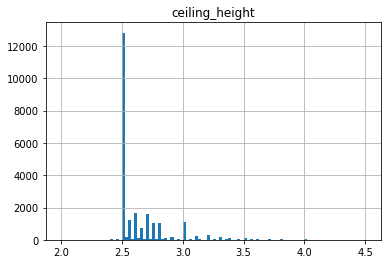

AxesSubplot(0.125,0.125;0.775x0.755)


(2, 4)

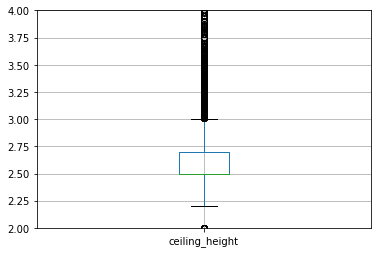

In [53]:
#Построим гистограмму и диаграмму размаха для анализа высоты потолков:
print(property_stat.hist(['ceiling_height'],bins=(100), range=(2,4.5)))
plt.show()
print(property_stat.boxplot(['ceiling_height']))
plt.ylim(2, 4)

#### Построим гистограмму и диаграмму размаха для анализа продолжительности размещения объявлений:

45.0      880
60.0      538
7.0       234
30.0      208
90.0      204
         ... 
1110.0      1
1049.0      1
951.0       1
693.0       1
773.0       1
Name: days_exposition, Length: 1141, dtype: int64
[[<matplotlib.axes._subplots.AxesSubplot object at 0x7fce4a50fa10>]]


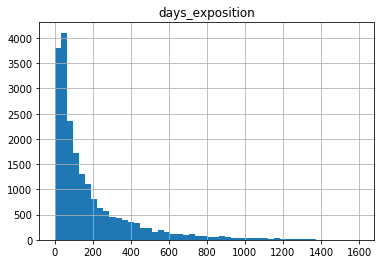

AxesSubplot(0.125,0.125;0.775x0.755)


(-100, 800)

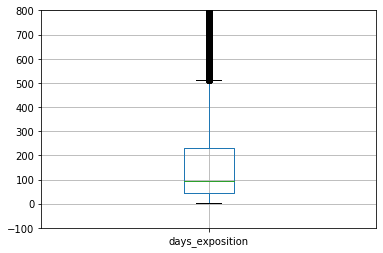

In [54]:
print(property_stat['days_exposition'].value_counts())
print(property_stat.hist(['days_exposition'], bins=(50), range=(0,1600)))
plt.show()
print(property_stat.boxplot(['days_exposition']))
plt.ylim(-100, 800)

#### Вывод:

1) Наиболее часто на продажу выставляют квартиры площадью 45 кв.м. Есть значительное количество выбросов в большую сторону. Также минимальная площадь равно 12кв.м., что странно.
2) Наблюдается большой разброс в ценах. Минимальная стоимость квартиры- 12000, максимальная 763 мкл.
3) Число комнат равное шести входит в номальное распределие. В выборке также есть квартиры, которые имеют до 19 комнат включительно. Они встречаются с низкой частотой, поэтому такие данные нужно будет отбросить.\
4) Наиболее часто высота потолков составляет 2.5 метра. Нормальным считается значение до 3 метров.
5) Минимальный срок размещения объявлений составляет один день. В большинстве случаев срок размещения- 45 дней.



### 4.2 Убираем редкие и выбивающиеся значения

In [55]:
property_stat=property_stat.query('26.9<total_area<=200')# удаляем выбросы по площадию. Min значение равно средней полощади студии
property_stat=property_stat.query('1000000<last_price<60000000')#удаляем выбросы по цене
property_stat=property_stat.query('rooms<=6')#удаляем выбросы по числу комнатproperty_stat=property_stat.query('2.0< ceiling_height< 3.0')#удаляем выбросы по высоте потолков
property_stat=property_stat.query('0< days_exposition <= (232+1.5*(232-45))')#удаляем выбросы по времени продажи

print(property_stat.info())    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18212 entries, 1 to 23695
Data columns (total 26 columns):
total_images            18212 non-null int64
last_price              18212 non-null float64
total_area              18212 non-null float64
first_day_exposition    18212 non-null datetime64[ns]
rooms                   18212 non-null int64
ceiling_height          18212 non-null float64
floors_total            18212 non-null int64
living_area             16704 non-null float64
floor                   18212 non-null int64
is_apartment            18212 non-null int64
studio                  18212 non-null int64
open_plan               18212 non-null int64
kitchen_area            16542 non-null float64
balcony                 18212 non-null int64
locality_name           18169 non-null object
airports_nearest        14208 non-null float64
cityCenters_nearest     14226 non-null float64
parks_around3000        14226 non-null float64
parks_nearest           6116 non-null float64
ponds_aro

Выборка уменьшилась до 18562 строк. Наибольшее число строк было отсеяно по параметру 'last_price'

### 4.3 Изучаем корреляцию

#### Зависимость стоимости квартиры от квадратного метра

0.7493549377482204


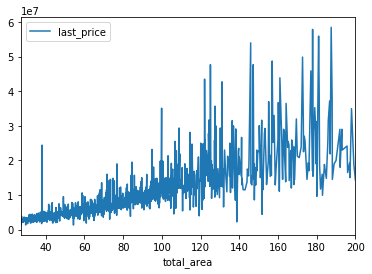

In [56]:
#считаем корреляцию:
print(property_stat['last_price'].corr(property_stat['total_area']))
#построим график зависимости:
(property_stat
     .pivot_table(index='total_area', values='last_price')
     .plot()
)


Конечно, цена квартиры напрямую зависит от её площади. Коэффициент корреляци довольно высокий - 0.7. Но график не гладкий, так как на цену могут влиять и другие фактора

#### Зависимость стоимости квартиры от числа комнат

0.4509748946681505


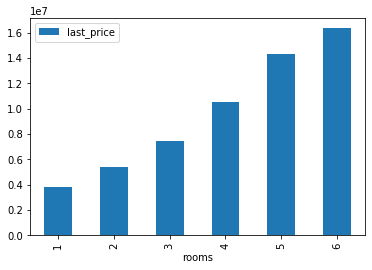

In [57]:
#считаем корреляцию:
print(property_stat['last_price'].corr(property_stat['rooms']))
#построим график зависимости:

(property_stat
     .pivot_table(index='rooms', values='last_price')
     .plot(kind='bar')
)


Коэффициент корреляции 0.45. Зависимость есть, стоимость увеличивается взависимости пока число комнат не достигнет 6. Затем стоимость начинает падать.

#### Зависимость цены от этажа

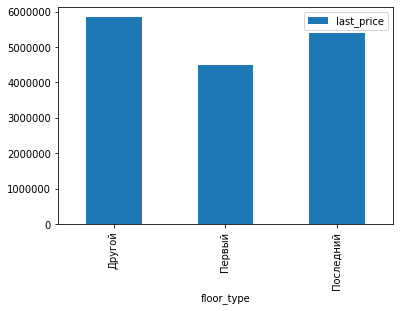

In [58]:
(property_stat
     .pivot_table(index='floor_type', values='last_price')
     .plot(kind='bar')
)

Наименьшую стоимость имеют квартиры на первом этаже. Квартиры на последнем этаже дороже, но меньше стоимость квартир на других этажах.

#### Зависимость цены от удаленности от центра

-0.3228618979934859


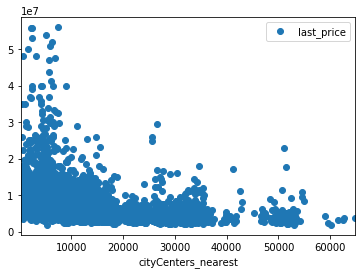

In [59]:
#считаем корреляцию:
print(property_stat['last_price'].corr(property_stat['cityCenters_nearest']))
#построим график зависимости:
(property_stat
     .pivot_table(index='cityCenters_nearest', values='last_price',)
     .plot(style='o')
)


Существует обратная зависимость, чем ближе к центру тем выше стоимость квартиры.

#### Зависимость цены от даты размещения

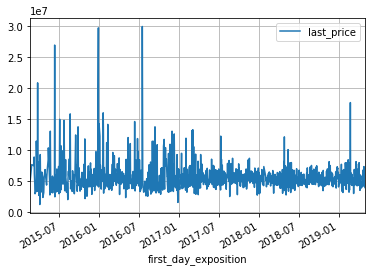

In [60]:
property_stat['first_day_exposition']=property_stat['first_day_exposition'].dt.round('D')

#построим график зависимости:
(property_stat
     .pivot_table(index='first_day_exposition', values='last_price')
     .plot(grid=True)
)


C 2015 года по 2019 разброс цен стал гораздо меньше. Со второй половине 2018 по вторую половину 2019 цены остаются примерно на одном уровне.

### 4.4 Изучим десять населенных пунктов с наибольшим числом объявлений

In [61]:
# посчитаем количество объявлений для каждого населенного пункта и выведим топ-10:
top_name = property_stat['locality_name'].value_counts().head(10)

#создадим таблицу населённых пунктов по стоимости квадратного метра для топ-10 по числу объявлений:
top_price_metr=(property_stat
    .query('locality_name in @top_name.index')             
    .pivot_table(index='locality_name', values='price_for_metr')
    .sort_values(by='price_for_metr', ascending=False)
)
    
print(top_price_metr)    

                   price_for_metr
locality_name                    
Санкт-Петербург     109508.719324
Пушкин              101828.116404
деревня Кудрово      91917.615056
посёлок Парголово    89445.358397
посёлок Мурино       84757.604353
посёлок Шушары       77180.658599
Колпино              74531.182651
Всеволожск           68691.745490
Гатчина              68300.437921
Выборг               56982.877246


Самая высокая стоимость жилья в топе-10 и набольшее кол-во объявлений в Санкт-Петербурге, а самая низкая в Выборге.

### 4.5 Определяем центральную зону Санкт-Петербурга

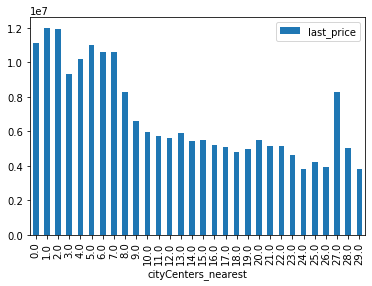

In [62]:
# делаем срез данных для Санкт-Петербурга:
property_stat_peterburg =property_stat.query('locality_name=="Санкт-Петербург"').reset_index(drop=True)

# создаем столбец с расстояниями до центра в км:
property_stat_peterburg['cityCenters_nearest']=(property_stat_peterburg['cityCenters_nearest']/1000).round(0)

# считаем среднюю цену для каждого км и построим график зависимости:
(property_stat_peterburg
    .pivot_table(index='cityCenters_nearest',values='last_price')
    .plot(kind='bar')
) 



Область в районе 7 км находится в центре.

### 4.6 Изучим параметры, от которых зависит цена квартиры в центре

In [63]:
property_stat_peterburg=property_stat_peterburg.loc[:,['rooms','total_area','cityCenters_nearest','floor_type',
                                                       'last_price','ceiling_height','first_day_exposition']] 
property_stat_peterburg_cent=property_stat_peterburg.query('cityCenters_nearest<=7')
print(property_stat_peterburg_cent.describe(include='all'))

              rooms   total_area  cityCenters_nearest floor_type  \
count   2354.000000  2354.000000          2354.000000       2354   
unique          NaN          NaN                  NaN          3   
top             NaN          NaN                  NaN     Другой   
freq            NaN          NaN                  NaN       1679   
first           NaN          NaN                  NaN        NaN   
last            NaN          NaN                  NaN        NaN   
mean       2.587935    79.376321             4.570093        NaN   
std        1.116331    34.370346             1.667282        NaN   
min        1.000000    27.000000             0.000000        NaN   
25%        2.000000    53.000000             4.000000        NaN   
50%        3.000000    72.500000             5.000000        NaN   
75%        3.000000    97.000000             6.000000        NaN   
max        6.000000   198.000000             7.000000        NaN   

          last_price  ceiling_height first_day_

#### Построим гистограмму для каждого параметра

[[<matplotlib.axes._subplots.AxesSubplot object at 0x7fce4a457990>]]
[[<matplotlib.axes._subplots.AxesSubplot object at 0x7fce4b2bb690>]]
[[<matplotlib.axes._subplots.AxesSubplot object at 0x7fce4da754d0>]]
[[<matplotlib.axes._subplots.AxesSubplot object at 0x7fce4a9f10d0>]]
[[<matplotlib.axes._subplots.AxesSubplot object at 0x7fce4a91a6d0>]]


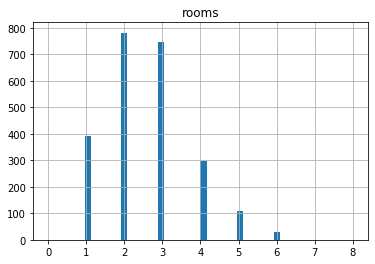

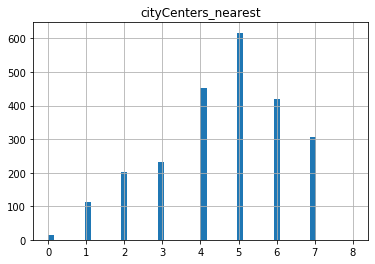

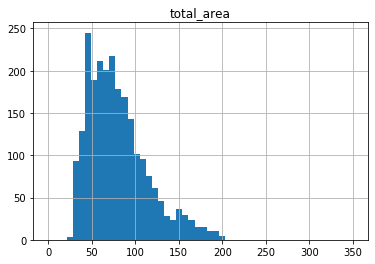

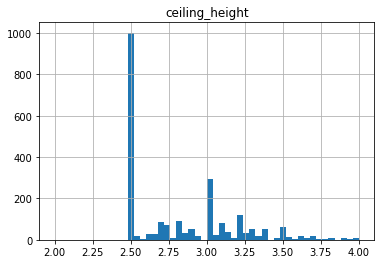

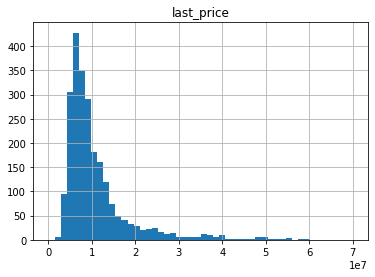

In [64]:
print(property_stat_peterburg_cent.hist(['rooms'], bins=(50), range=(0,8)))
print(property_stat_peterburg_cent.hist(['cityCenters_nearest'], bins=(50), range=(0,8)))
print(property_stat_peterburg_cent.hist(['total_area'], bins=(50), range=(0,350)))
print(property_stat_peterburg_cent.hist(['ceiling_height'], bins=(50), range=(2,4)))
print(property_stat_peterburg_cent.hist(['last_price'], bins=(50), range=(0,70000000)))

Стандартная квартира для центра: 2-3 комнатная квартира, с высотой потолков 2.5 метра, площадью 45 кв.м, стоимостью 7.8 млн.

### 4.7 Факторы, влияющие на стоимоcть квартир в центре

#### Зависимость стоимости квартиры в центре от площади

0.6808336218862843


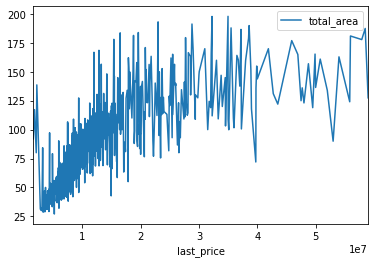

In [65]:
#считаем корреляцию:
print(property_stat_peterburg_cent['last_price'].corr(property_stat_peterburg_cent['total_area']))
#построим график зависимости:
(property_stat_peterburg_cent
     .pivot_table(index='last_price', values='total_area')
     .plot()
)

#### Зависимость цены квартиры в центре от числа комнат:

0.37336670262540694


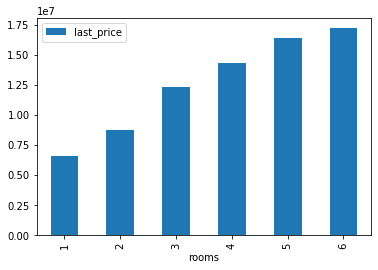

In [66]:
#считаем корреляцию:
print(property_stat_peterburg_cent['last_price'].corr(property_stat_peterburg_cent['rooms']))
#построим график зависимости:

(property_stat_peterburg_cent
     .pivot_table(index='rooms', values='last_price')
     .plot(kind='bar')
)

#### Зависимость цены квартиры в центре от этажа

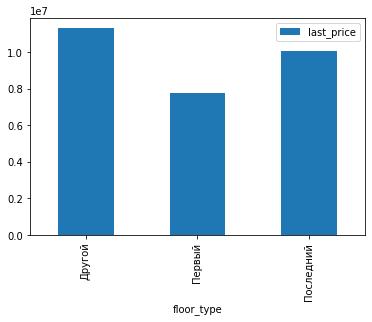

In [67]:
#построим график зависимости:
(property_stat_peterburg_cent
     .pivot_table(index='floor_type', values='last_price')
     .plot(kind='bar')
)

####  Зависимость цены квартиры в центре от удаленности от центра

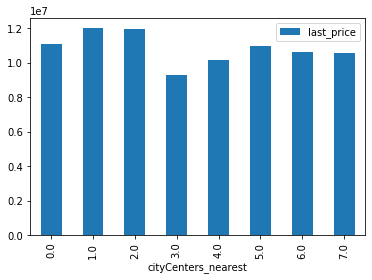

In [68]:
 #построим график зависимости:
(property_stat_peterburg_cent
     .pivot_table(index='cityCenters_nearest', values='last_price')
     .plot(kind='bar')
)

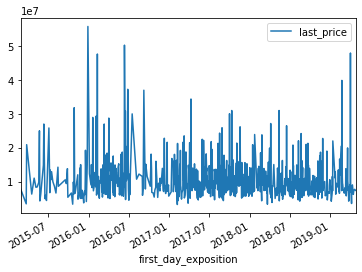

In [69]:
#построим график зависимости:
(property_stat_peterburg_cent
     .pivot_table(index='first_day_exposition', values='last_price')
     .plot()
)


### Вывод

1) Есть прямая зависомть цены от площади квартиры.
2) Коэффициент корреляции цены и числа комнат 0.45. Зависимость есть, стоимость увеличивается взависимости пока число комнат не достигнет 6. Затем стоимость начинает падать.
3) Наименьшую стоимость имеют квартиры на первом этаже. Квартиры на последнем этаже дороже, но меньше стоимость квартир на других этажах.
4) Дороже всего квартиры в 1 км от центра. Квариры в самом центре стоят дешевле всех остальных.
5) Цена квартир в течение всего периода наблюдений растет в первой половине года, а во-второй падает.

### Шаг 5. Общий вывод

1)В целом рыночная стоимость квартир напрямую свзяна с её площадь. 
2)Чем больше комнат,тем выше стоимость. Но такая связь действует только для квартир до 6 комнат. Наиболее дорогие квартиры на промежуточных этаж, квартиры на первом этаже стоят дешевле. 
3)Чем ближе к центру, тем дороже. При этом квартиры в самом центре дешевле, чем водном километре от центра.
4) Хотя цена средняя цена колеблется в течение всего года, но на шестом-седьмом месяце цены поднимаются.




